In [1]:
# imports

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import sklearn.tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import KFold, StratifiedKFold, learning_curve
from sklearn import metrics, neighbors
from sklearn.pipeline import Pipeline

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

plt.style.use("CJ_style.mplstyle") #personal plotting style

In [2]:
df = pd.read_csv('phl_exoplanet_catalog.csv', sep=',')
df.keys()

Index(['P_NAME', 'P_STATUS', 'P_MASS', 'P_MASS_ERROR_MIN', 'P_MASS_ERROR_MAX',
       'P_RADIUS', 'P_RADIUS_ERROR_MIN', 'P_RADIUS_ERROR_MAX', 'P_YEAR',
       'P_UPDATED',
       ...
       'P_HABZONE_CON', 'P_TYPE_TEMP', 'P_HABITABLE', 'P_ESI',
       'S_CONSTELLATION', 'S_CONSTELLATION_ABR', 'S_CONSTELLATION_ENG',
       'P_RADIUS_EST', 'P_MASS_EST', 'P_SEMI_MAJOR_AXIS_EST'],
      dtype='object', length=112)

# Preliminary Data Analysis & Exploration

The first step when working with research-level data is to embark on some exploration. Begin with looking for missing data and statistical oddities. In our example of exoplanet data from January 2020, we will find that many exoplanets are missing data in one or more features.

There are multiple ways of handling missing data. For now we will eliminate any object which is missing feature data. Later I will explore ways of imputing.

It will also be important to search the data for outliers which could skew the results of our classifier and remove them. This is often done by finding instances that are some amount of standard deviations away from the mean (think $\sigma$-clipping). Here, I will reject outliers with a z-score of 5 (i.e., the object has a feature value that is 5$\sigma$ away from the mean for the dataset).

In [3]:
"""
Looking at the summary statistics, we see that the mean and median of many features are far away
from each other, showing the distributions to be skewed.
"""

df.describe()

,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_PERIOD,P_PERIOD_ERROR_MIN,...,S_SNOW_LINE,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_HABITABLE,P_ESI,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
count,4048.0,1598.000000,1467.000000,1467.000000,3139.000000,3105.000000,3105.000000,4048.000000,3.938000e+03,3.807000e+03,...,3786.000000,3.083000e+03,3281.000000,4048.000000,4048.000000,4048.000000,3721.000000,4048.000000,4048.000000,3978.000000
mean,3.0,798.384920,-152.292232,190.289692,4.191426,-0.483990,0.621867,2014.212945,2.309342e+03,-1.073631e+03,...,3.513348,1.768991e+35,0.440103,0.049654,0.034091,0.021986,0.261252,5.588647,323.089993,4.011385
std,0.0,1406.808654,783.366353,1082.061976,4.776830,1.409048,2.007592,3.704839,1.167012e+05,5.943181e+04,...,5.463171,6.944274e+36,0.074285,0.217256,0.181485,0.195731,0.131333,5.392733,965.084290,62.389968
min,3.0,0.019070,-24965.390000,0.000000,0.336300,-54.592700,0.000000,1989.000000,9.070629e-02,-3.650000e+06,...,0.002405,7.293660e-05,0.030707,0.000000,0.000000,0.000000,0.006768,0.000000,0.000000,0.004400
25%,3.0,26.548968,-79.457001,4.449592,1.569400,-0.526870,0.145730,2014.000000,4.497336e+00,-1.129000e-03,...,1.740762,5.264169e-01,0.420337,0.000000,0.000000,0.000000,0.196982,1.703920,3.628101,0.053000
50%,3.0,273.332080,-24.154928,25.108412,2.331680,-0.235410,0.325090,2016.000000,1.187053e+01,-9.392000e-05,...,2.568600,1.429118e+00,0.448357,0.000000,0.000000,0.000000,0.271192,2.667980,7.815324,0.102199
75%,3.0,806.488560,-4.392383,85.813561,3.553570,-0.134520,0.661390,2016.000000,4.186661e+01,-1.594000e-05,...,3.661581,2.641037e+00,0.472140,0.000000,0.000000,0.000000,0.303346,11.770500,149.379160,0.260507
max,3.0,17668.059000,0.270000,26630.808000,77.349000,0.450000,68.919080,2019.000000,7.300000e+06,3.200000e-02,...,104.112780,2.726899e+38,1.322542,1.000000,1.000000,2.000000,0.931208,77.349000,17668.059000,2500.000000


In [4]:
df.groupby('P_HABITABLE').count() #summary stats by class

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,...,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
P_HABITABLE,,,,,,,,,,,,,,,,,,,,,
0,3993,3993,1575,1444,1444,3101,3067,3067,3993,3993,...,3993,3993,3666,3666,3993,3993,3993,3993,3993,3923
1,21,21,16,16,16,9,9,9,21,21,...,21,21,21,21,21,21,21,21,21,21
2,34,34,7,7,7,29,29,29,34,34,...,34,34,34,34,34,34,34,34,34,34


In [5]:
"""
In the dataset provided there are actually three possible values for the habitability label:
0 -> Not Habitable
1 -> Optimistically Habitable
2 -> Possibly Habitable

Because we are here dealing only with a binary classifier, we will combine values 1 and 2
"""

bindf = df.drop('P_HABITABLE', axis=1) #make a copy of the dataframe that does not have the habitability class

bindf['P_HABITABLE'] = (np.logical_or((df.P_HABITABLE == 1), (df.P_HABITABLE == 2))) #create a new habitability class
bindf['P_HABITABLE'] = bindf['P_HABITABLE'].astype(int) #make sure the values are integers

In [6]:
bindf

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,...,P_HABZONE_CON,P_TYPE_TEMP,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST,P_HABITABLE
0,11 Com b,3.0,6165.86330,-476.74200,476.74200,NaN,NaN,NaN,2007,2014-05-14,...,0,Hot,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.863300,1.29000,0
1,11 UMi b,3.0,4684.78480,-794.57001,794.57001,NaN,NaN,NaN,2009,2018-09-06,...,0,Hot,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.784800,1.53000,0
2,14 And b,3.0,1525.57440,NaN,NaN,NaN,NaN,NaN,2008,2014-05-14,...,0,Hot,0.081917,Andromeda,And,Andromeda,12.848516,1525.574400,0.83000,0
3,14 Her b,3.0,1481.07850,-47.67420,47.67420,NaN,NaN,NaN,2002,2018-09-06,...,0,Cold,0.145241,Hercules,Her,Hercules,12.865261,1481.078500,2.93000,0
4,16 Cyg B b,3.0,565.73385,-25.42624,25.42624,NaN,NaN,NaN,1996,2018-09-06,...,1,Warm,0.368627,Cygnus,Cyg,Swan,13.421749,565.733850,1.66000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4043,K2-296 b,3.0,NaN,NaN,NaN,1.87,0.45,0.2,2019,5/23/19,...,0,Warm,0.755038,Virgo,Vir,Virgin,1.870000,4.155456,0.13456,1
4044,K2-296 c,3.0,NaN,NaN,NaN,2.76,NaN,NaN,2019,5/23/19,...,0,Hot,0.363831,Virgo,Vir,Virgin,2.760000,8.047485,0.05769,0
4045,GJ 1061 b,3.0,1.38000,0.15000,0.16000,NaN,NaN,NaN,2019,9/3/19,...,0,Hot,0.588562,Horologium,Hor,Pendulum Clock,1.102775,1.380000,0.02100,0
4046,GJ 1061 c,3.0,1.75000,0.23000,0.23000,NaN,NaN,NaN,2019,9/3/19,...,0,Warm,0.879042,Horologium,Hor,Pendulum Clock,1.178333,1.750000,0.03500,1


In [7]:
"""
There are many columns we could (and should!) use in our analysis, but for now I'll use the same three
features as in the DT & kNN notebook.
"""

final_features = bindf[['S_MASS', 'P_PERIOD', 'P_DISTANCE']]

targets = bindf.P_HABITABLE

In [8]:
final_features

,S_MASS,P_PERIOD,P_DISTANCE
0,2.70,326.030000,1.324418
1,2.78,516.219970,1.534896
2,2.20,185.840000,0.830000
3,0.90,1773.400000,3.130558
4,1.08,798.500000,2.043792
...,...,...,...
4043,0.41,28.165600,0.134560
4044,0.41,7.906961,0.057690
4045,0.12,3.204000,0.021000
4046,0.12,6.689000,0.035000


In [9]:
final_features.shape, final_features.describe(), final_features.isnull().sum()

((4048, 3),
             S_MASS      P_PERIOD   P_DISTANCE
 count  3283.000000  3.938000e+03  3978.000000
 mean      1.003838  2.309342e+03     4.047677
 std       0.652903  1.167012e+05    62.435994
 min       0.010000  9.070629e-02     0.004408
 25%       0.810000  4.497336e+00     0.053110
 50%       0.970000  1.187053e+01     0.103000
 75%       1.130000  4.186661e+01     0.263415
 max      23.560000  7.300000e+06  2500.000000,
 S_MASS        765
 P_PERIOD      110
 P_DISTANCE     70
 dtype: int64)

In [10]:
final_features = final_features.dropna(axis=0) # drop any instance with at least one NaN
final_features.shape

(3180, 3)

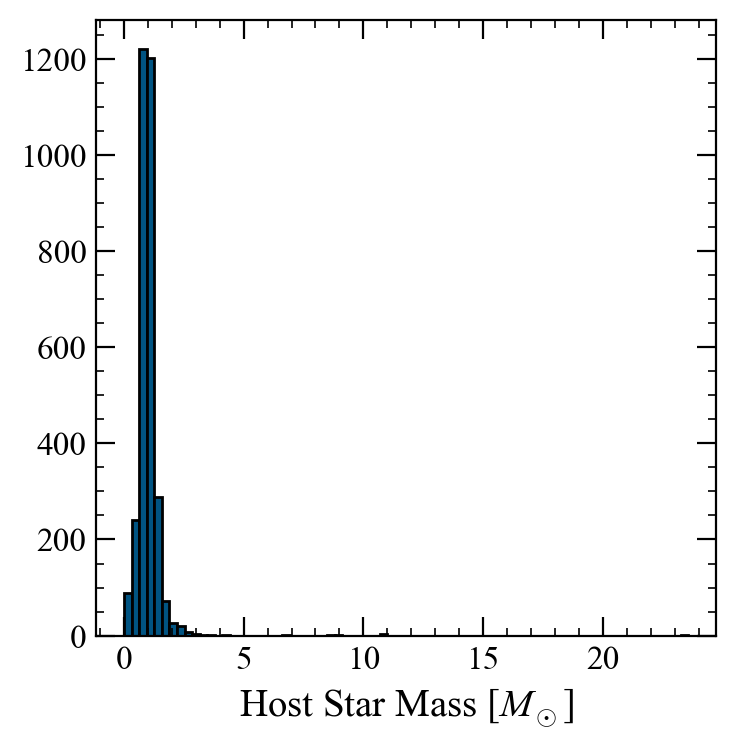

In [11]:
fig, ax = plt.subplots(1, 1)

ax.hist(final_features.iloc[:,0], bins=75, color='xkcd:deep sea blue', edgecolor='k')
ax.set_xlabel('Host Star Mass [$M_\odot$]')

plt.show()

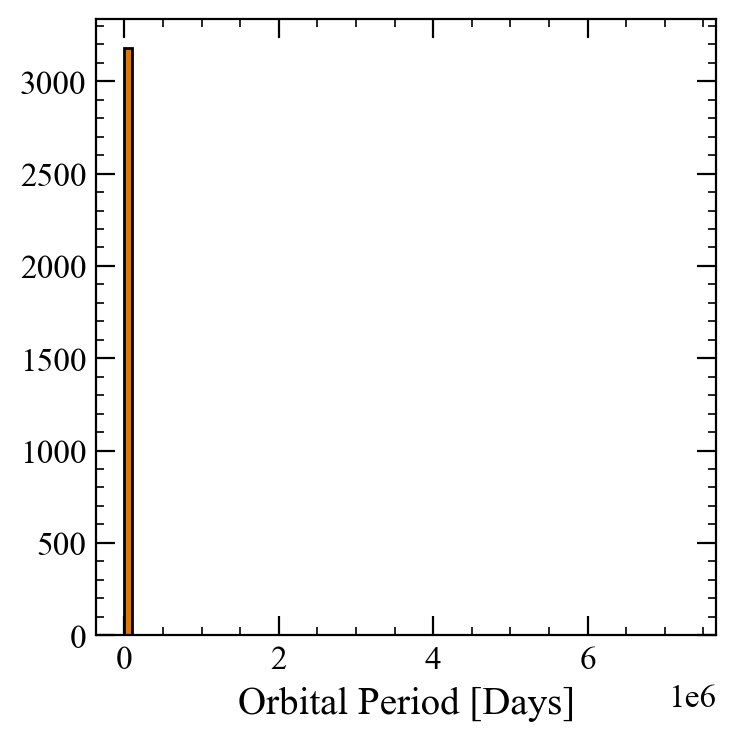

In [12]:
fig, ax = plt.subplots(1, 1)

ax.hist(final_features.iloc[:,1], bins=75, color='xkcd:pumpkin', edgecolor='k')
ax.set_xlabel('Orbital Period [Days]')

plt.show()

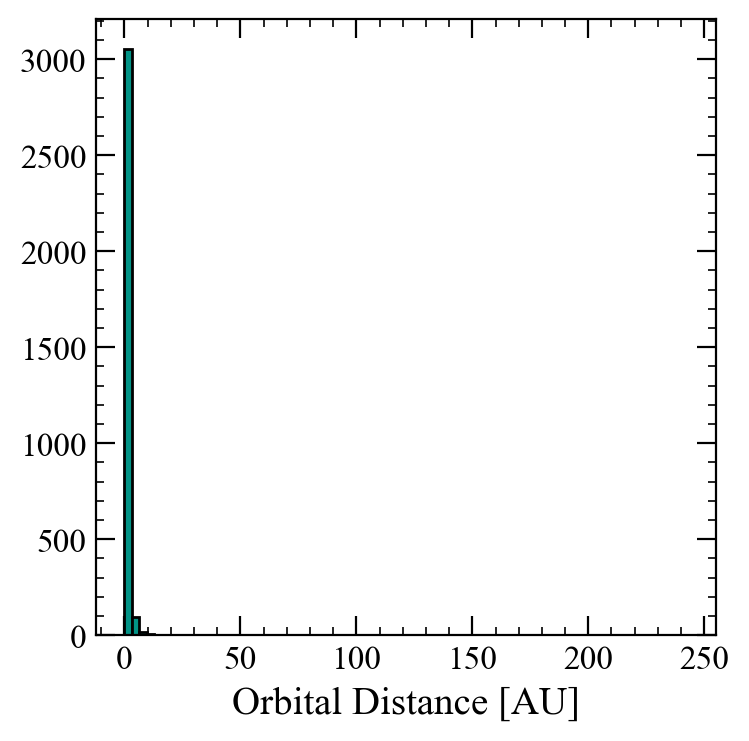

In [13]:
fig, ax = plt.subplots(1, 1)

ax.hist(final_features.iloc[:,2], bins=75, color='xkcd:teal', edgecolor='k')
ax.set_xlabel('Orbital Distance [AU]')

plt.show()

In [14]:
final_features = final_features[(abs(stats.zscore(final_features)) < 5).all(axis=1)]
# **Note**:
# The above eliminates any object with a feature greater than 5 sigma away from the *mean*, so it may
# not be ideal. It should really be 5x the difference between the 25 and 75 percentiles away from 
# the median. I can probably code this later.

In [15]:
targets = targets[final_features.index]

In [16]:
final_features = final_features.reset_index(drop=True)
targets = targets.reset_index(drop=True)

In [17]:
final_features.shape

(3171, 3)

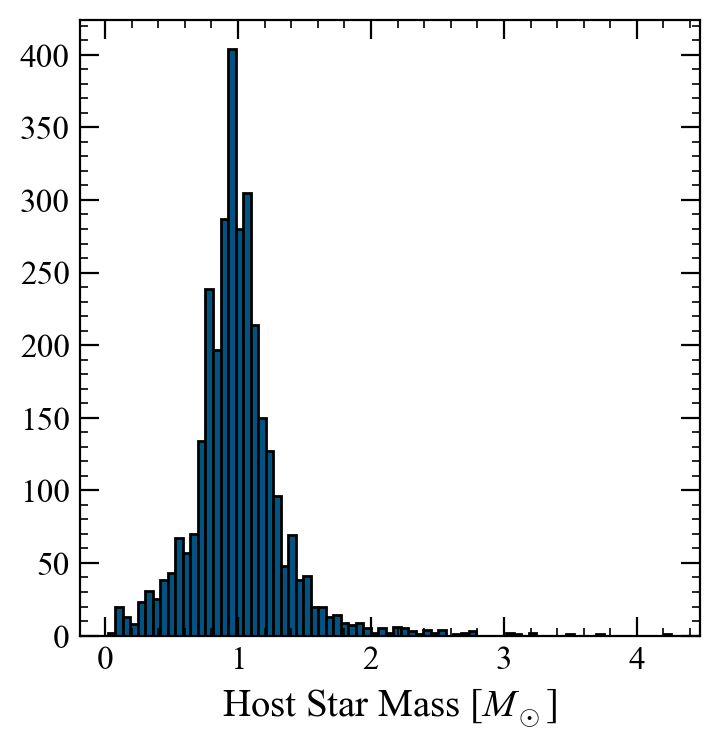

In [18]:
"""
A total of 9 outliers have been removed, and we can see from the plot below that the range
has narrowed for the mass of the host star.
"""

fig, ax = plt.subplots(1, 1)

ax.hist((final_features.iloc[:,0]), bins=75, color='xkcd:deep sea blue', edgecolor='k')
ax.set_xlabel('Host Star Mass [$M_\odot$]')

plt.show()

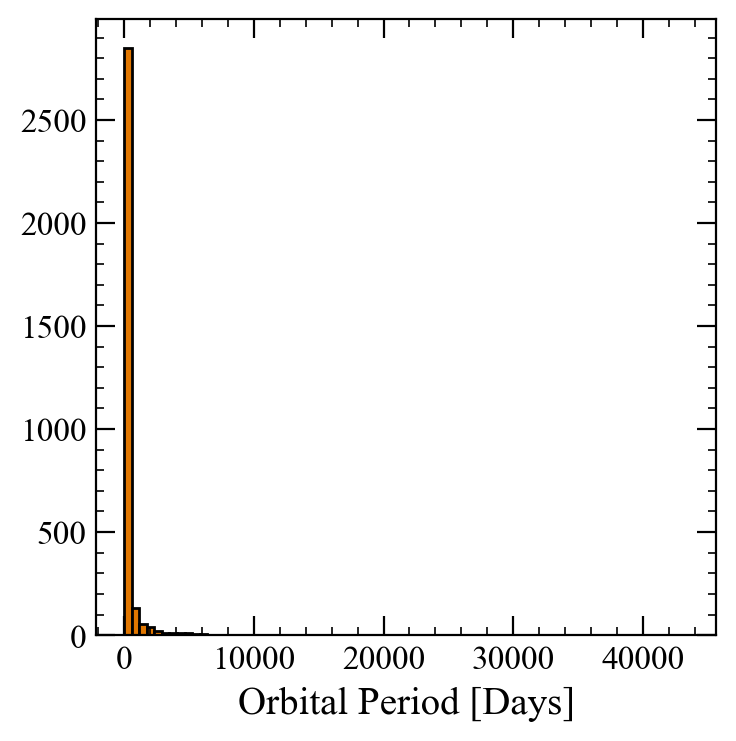

In [19]:
fig, ax = plt.subplots(1, 1)

ax.hist(final_features.iloc[:,1], bins=75, color='xkcd:pumpkin', edgecolor='k')
ax.set_xlabel('Orbital Period [Days]')

plt.show()

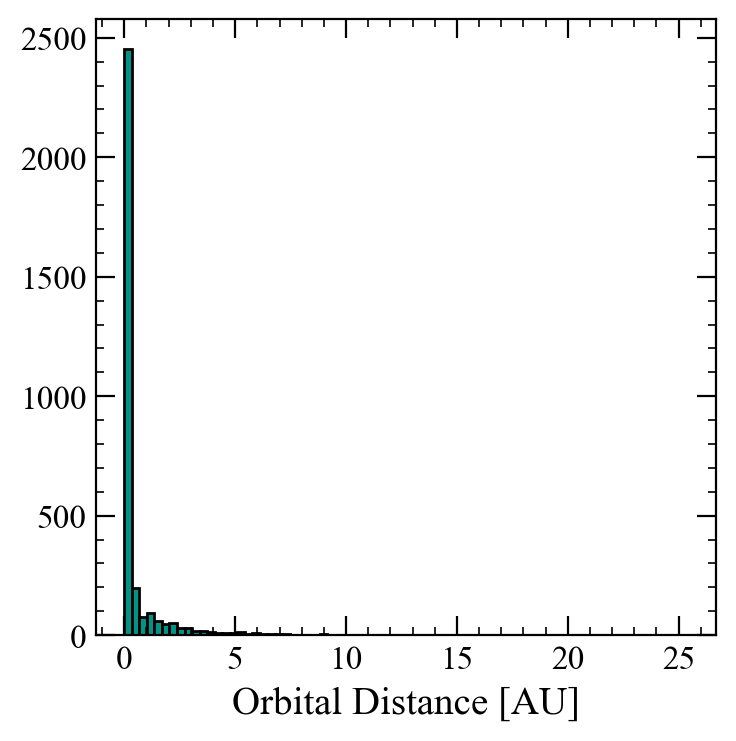

In [20]:
fig, ax = plt.subplots(1, 1)

ax.hist(final_features.iloc[:,2], bins=75, color='xkcd:teal', edgecolor='k')
ax.set_xlabel('Orbital Distance [AU]')

plt.show()

In [21]:
"""
Another aspect of the dataset we need to investigate is how balanced it is. We have two targets:
'Habitable' and 'Not Habitable'. In a balanced dataset the instances of each would be roughly equal. Here
we see that, on the contrary, we have 3119 'Not Habitable' planets and only 52 which are deemed habitable.
This dataset is high imbalanced and we therefore need to exercise caution.
"""

np.bincount(targets)

array([3119,   52], dtype=int64)

In [22]:
pd.concat([final_features, targets], axis=1).groupby('P_HABITABLE').describe(percentiles=[])

S_MASS                                        P_PERIOD  \
              count      mean       std   min    50%   max    count   
P_HABITABLE                                                           
0            3119.0  1.003520  0.341290  0.02  0.980  4.26   3119.0   
1              52.0  0.486538  0.285079  0.08  0.475  1.12     52.0   

                                                                        \
                   mean          std       min        50%          max   
P_HABITABLE                                                              
0            296.532141  1340.624871  0.090706  11.230000  43500.00000   
1             91.035689   100.689713  4.049610  47.481207    448.30356   

            P_DISTANCE                                                     
                 count      mean       std       min       50%        max  
P_HABITABLE                                                                
0               3119.0  0.534470  1.370882  0.004408  0.095352  25.426153  
1                 52.0  0.302263  0.276637  0.021493  0.205800   1.190229

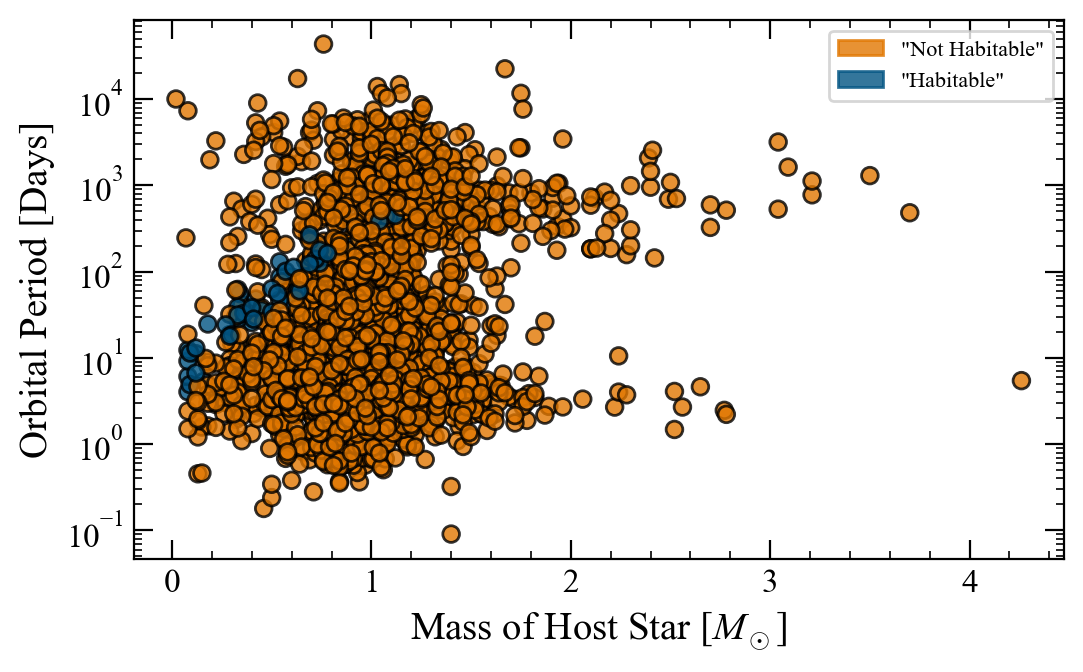

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['xkcd:pumpkin','xkcd:deep sea blue'])

ax.scatter(final_features['S_MASS'], final_features['P_PERIOD'], edgecolor='xkcd:black',
          marker='o', c=targets, cmap=cmap, alpha=0.8)

bluepatch = mpatches.Patch(color='xkcd:deep sea blue', label='"Habitable"', alpha=0.8)
orangepatch = mpatches.Patch(color='xkcd:pumpkin', label='"Not Habitable"', alpha=0.8)

ax.legend(handles=[orangepatch, bluepatch], loc='upper right')

ax.set_yscale('log')
ax.set_xlabel('Mass of Host Star $[M_\odot]$')
ax.set_ylabel('Orbital Period [Days]')

plt.show()

In [24]:
"""
This time, when constructing the training and test sets I'll let the split be random.
"""

Xtrain, Xtest, ytrain, ytest = train_test_split(final_features, targets, random_state=2)
Xtrain.shape, Xtest.shape

((2378, 3), (793, 3))

In [25]:
"""
Starting with the DT
"""

model = DecisionTreeClassifier(random_state=5)
model.fit(Xtrain, ytrain)

DecisionTreeClassifier(random_state=5)

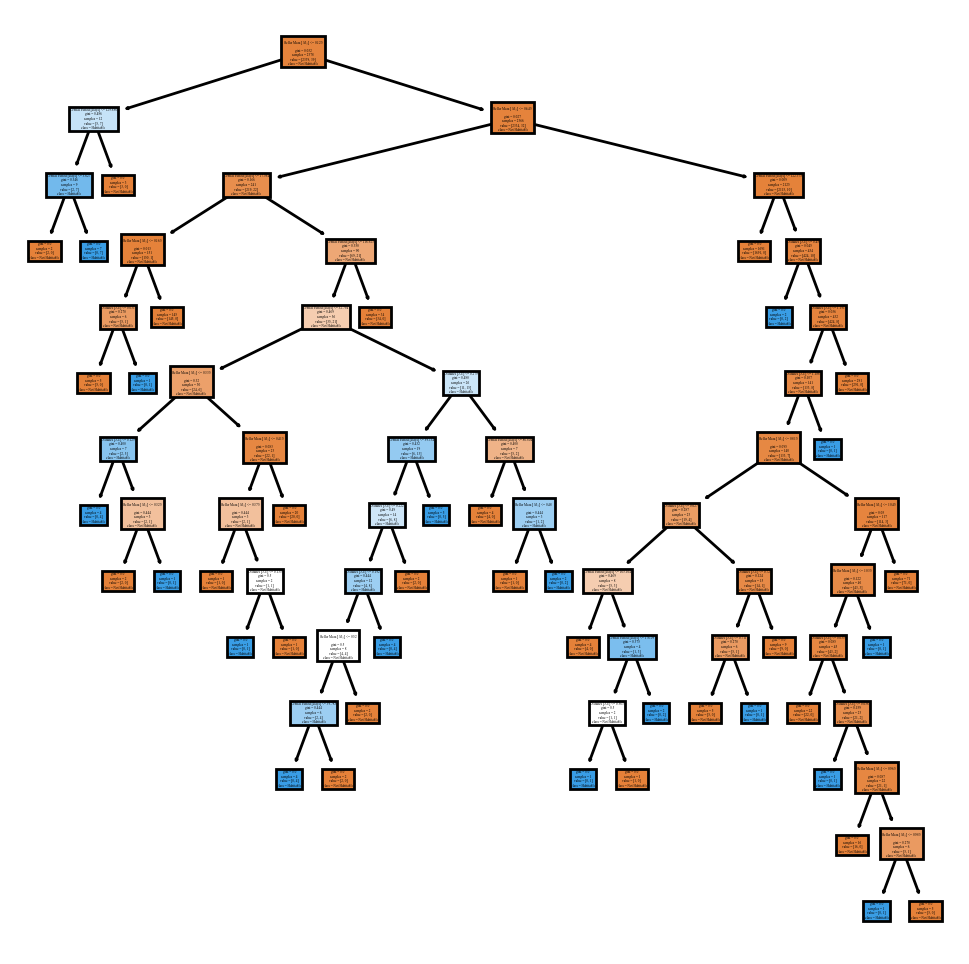

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

sklearn.tree.plot_tree(model, feature_names = ['Stellar Mass [$M_\odot$]', 'Orbital Period [Days]', 'Distance [AU]'],
              class_names = ['Not Habitable', 'Habitable'], ax=ax, filled=True)

plt.show()

In [27]:
"""
This tree is unreadable... Worse, it has likely come up with hyper-specific splits to explain just
the training set. Let's see
"""

metrics.accuracy_score(ytrain, model.predict(Xtrain)), metrics.accuracy_score(ytest, model.predict(Xtest))

(1.0, 0.9848675914249685)

In [28]:
"""
The model gets a perfect score with the training set, and a 98.49% accuracy score on the test set.
But given the fact only 52 planets are habitable out of 3171, is this any better than a classifier
that just always guesses "Not Habitable"?
"""

metrics.accuracy_score(ytest, np.zeros_like(ytest))

0.9836065573770492

# Evaluation Metrics
### Accuracy, Precision, and Recall

In a binary classifier there are four different outcomes. The classifier can give a positive or a negative output, which can either be true or false. Thus, we have true positives (TP), false positives (FP), true negatives (TN) and false negatives (FN). These outcomes can be combined in various 

$\bullet$ *Accuracy* is the total number of correct classifications over the total number:
$$\mathrm{Accuracy}=\frac{\mathrm{TN+TP}}{\mathrm{TN+TP+FN+FP}}$$

$\bullet$ *Precision* is the fraction of correct positive classifications and answers the question "Out of all the positive classifications, how many truly belong to the positive class?" Another term for the precision is the *purity*:
$$\mathrm{Precision}=\frac{\mathrm{TP}}{\mathrm{TP+FP}}$$

$\bullet$ *Recall* is teh fraction of correctly identified positive examples and answers how many of the truly positive class our model has actually captured. This is also known as the *completeness*.
$$\mathrm{Recall}=\frac{\mathrm{TP}}{\mathrm{TP+FN}}$$

Other metrics can be crafted by combining the four outcomes, and in practice researchers will make bespoke metrics for their projects.

In [29]:
metrics.precision_score(ytest, model.predict(Xtest))

0.5384615384615384

In [30]:
metrics.recall_score(ytest, model.predict(Xtest))

0.5384615384615384

In [31]:
"""
So our purity and completeness are both ~50%... so even though we have a high accuracy with the DT, it
does not do a great job in other metrics. A useful representation of this is the confusion matrix.
"""

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap='bone'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
        
    fig, ax = plt.subplots(1, 1)
    
    print(cm)
    sc = ax.imshow(cm, interpolation='nearest', cmap=cmap, alpha=0.8)
    ax.set_title(title)
    plt.colorbar(sc)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks, classes, rotation=45)
    ax.set_yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i,j ], fmt), 
                    horizontalalignment='center', verticalalignment='center',
                    color='xkcd:ocean' if i == j else 'xkcd:twilight', fontsize=30)
            
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    
    plt.show()

Confusion matrix, without normalization
[[774   6]
 [  6   7]]


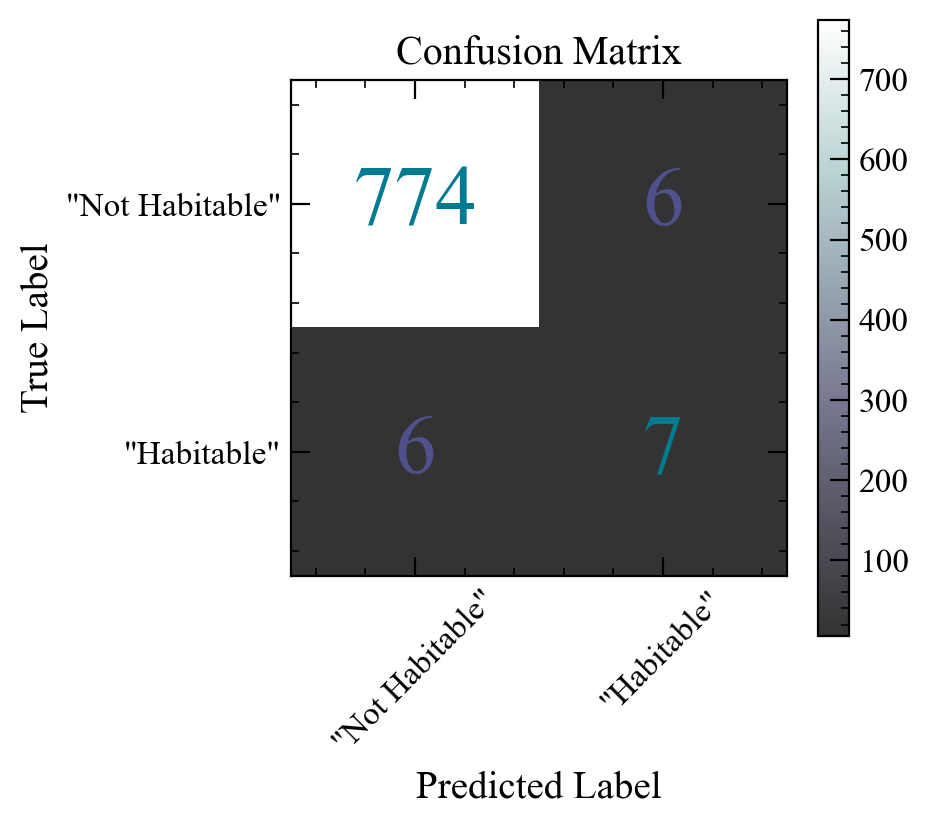

In [32]:
cm = metrics.confusion_matrix(ytest, model.predict(Xtest))

plot_confusion_matrix(cm, ['"Not Habitable"', '"Habitable"'])

# Receiver Operating Characteristic curve (ROC)

We can think of recasting our classification problem as a regression problem. How? We can assign a threshold of acceptance. The default is that if the algorithm is $\ge$50% confident of a classification, it will assign the object to that classification. We can always tweek this value, with the downstream effect of altering our confusion matrix by changing the number of instances of TPs, FPs, TN's, and FN's.

The idea of the ROC is to plot the rate of flase positives versus the rate of true positives for different values of the threshold.

*I'll come back to this later*

# Cross Validation

When we pick a single test/train split we are running the risk of significantly over-/underestimating the performance of our algorithm. What we would like is to have a *typical* performance quantified by a metric of our choice. It also seems like a waste that a significant amount of training data is not put to use once it is assigned to the test set. Both issues can be solved by *cross validation*.

The general idea is fairly intuitive. We choose many different test/train splits and repeat the training process each time. The performance is estimated as the mean (or median) of the test scores obtained in all the attempts and the standard deviation (or dispersion measure) provides an estimate of the uncertainty. The most common strategy for this is *k-fold cross validation* where $k$ iterations are performed, cycling through folds so that we use one as the test set and teh remaining $k-1$ folds are the train set. **Note:** *the data set must be suffled before employing this technique*.

Something else to consider here is that our data are extremely imbalanced. We can mitigate the effects of this by using a stratified k-fold approach. It is *stratified* in the sense that each split is selected to "look like" the entire dataset.

In [33]:
cv = KFold(shuffle=True, n_splits=5, random_state=5)
cv_strat = StratifiedKFold(shuffle=True, n_splits=5, random_state=5)

In [34]:
for train, test in cv.split(final_features, targets):
    print('Train - {} | Test - {}'.format(np.bincount(targets.iloc[train]), np.bincount(targets.iloc[test])))

Train - [2491   45] | Test - [628   7]
Train - [2496   41] | Test - [623  11]
Train - [2498   39] | Test - [621  13]
Train - [2493   44] | Test - [626   8]
Train - [2498   39] | Test - [621  13]


In [35]:
for train, test in cv_strat.split(final_features, targets):
    print('Train - {} | Test - {}'.format(np.bincount(targets.iloc[train]), np.bincount(targets.iloc[test])))

Train - [2495   41] | Test - [624  11]
Train - [2495   42] | Test - [624  10]
Train - [2495   42] | Test - [624  10]
Train - [2495   42] | Test - [624  10]
Train - [2496   41] | Test - [623  11]


In [36]:
scores = cross_validate(DecisionTreeClassifier(), final_features, targets, cv=cv, scoring='accuracy')
scores_strat = cross_validate(DecisionTreeClassifier(), final_features, targets, cv=cv, scoring='accuracy')

scores['test_score'].mean(), scores_strat['test_score'].mean()

(0.9829692739511662, 0.9823388559079957)

In [37]:
scores = cross_validate(DecisionTreeClassifier(random_state=1), final_features, targets, cv=cv, scoring='recall')
scores_strat = cross_validate(DecisionTreeClassifier(random_state=1), final_features, targets, cv=cv_strat, scoring='recall')

scores['test_score'].mean(), scores_strat['test_score'].mean()

(0.44323176823176824, 0.4254545454545455)

In [38]:
"""We can include the train score as well, which can be helpful when diagnosing."""
scores = cross_validate(DecisionTreeClassifier(random_state=1), final_features, targets, cv=cv_strat,
                        scoring='recall', return_train_score=True)
scores['test_score'].mean(), scores['train_score'].mean()

(0.4254545454545455, 1.0)

In [39]:
"""
So far we've only looked at the summary statistics, but we can also return the predictions. The function
below saves the predictions for each of the k test folds and compiles them together.
"""

model = DecisionTreeClassifier(random_state=3)
y = cross_val_predict(model, final_features, targets, cv=cv_strat) #gives predictions independent of scoring parms

Confusion matrix, without normalization
[[3093   26]
 [  29   23]]


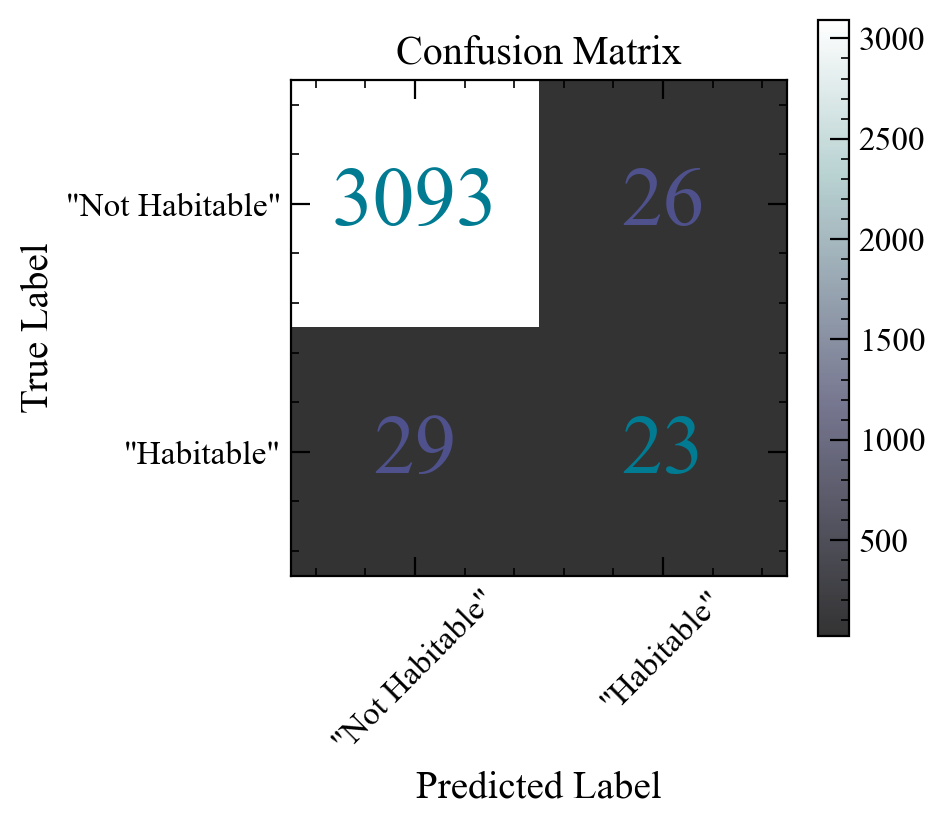

In [40]:
cm = metrics.confusion_matrix(targets, y)

plot_confusion_matrix(cm, ['"Not Habitable"', '"Habitable"'])

In [41]:
# We can do the same process for the kNN algorithm.


scaler = sklearn.preprocessing.RobustScaler() # robust against outliers
model = neighbors.KNeighborsClassifier()
"""
We can use the Pipeline function to apply a list of transformers to preprocess the data.
In this case it's just the scaler we made to normalize the dataset for the kNN.
"""
pipeline = Pipeline([('transformer', scaler), ('estimator', model)])

Confusion matrix, without normalization
[[3097   22]
 [  35   17]]


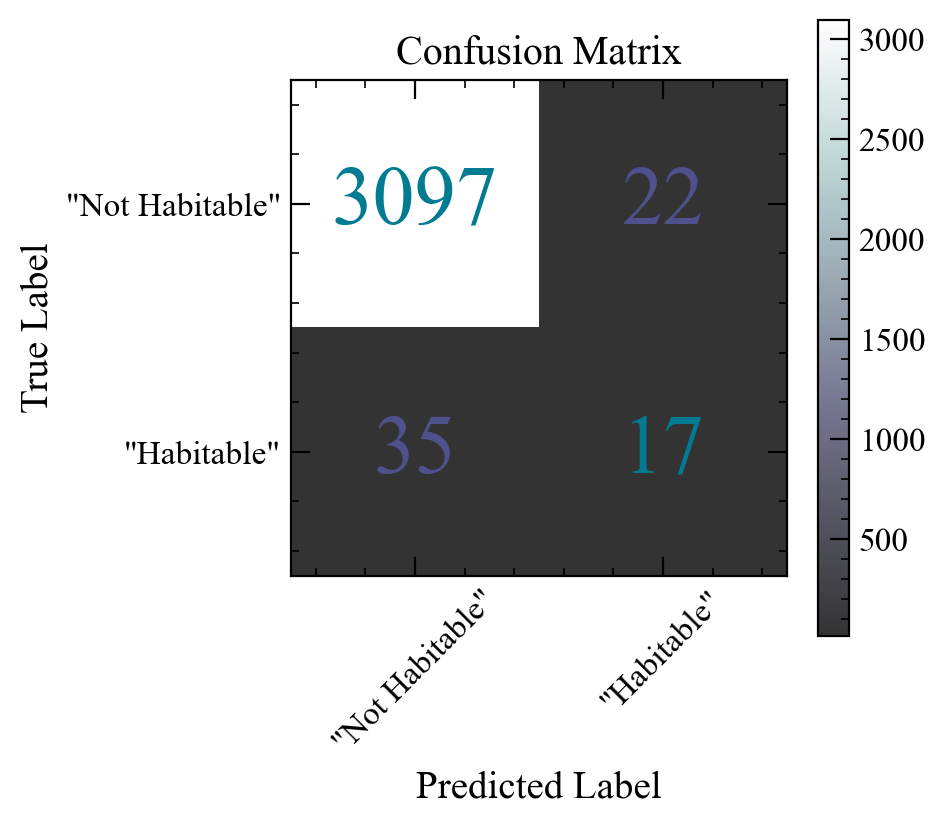

In [42]:
y = cross_val_predict(pipeline, final_features, targets, cv=cv_strat) #gives predictions independent of scoring parms

cm = metrics.confusion_matrix(targets, y)
plot_confusion_matrix(cm, ['"Not Habitable"', '"Habitable"'])

In [43]:
scores_acc = cross_validate(pipeline, final_features, targets, cv=cv, scoring='accuracy')
scores_pre = cross_validate(pipeline, final_features, targets, cv=cv, scoring='precision')
scores_rec = cross_validate(pipeline, final_features, targets, cv=cv, scoring='recall')

In [44]:
scores_acc['test_score'].mean(), scores_acc['test_score'].std()

(0.9836016791276485, 0.003246258547936974)

In [45]:
scores_pre['test_score'].mean(), scores_pre['test_score'].std()

(0.4650793650793651, 0.22846117270250252)

In [46]:
scores_rec['test_score'].mean(), scores_rec['test_score'].std()

(0.33993506493506487, 0.15444763029881572)

# Learning Curves

A useful diagnostic tool is the learning curve, a plot of metric versus the size of the training set. The test scores are obtained from the cross-validation processes. By looking at whether the current learning set size lies in the sloped or flat part of the curve we can guage the impact of gathering additional data. If we plot both the test and training scores we can also get a sense of whether our model has high variance or high bias.

$\bullet$ High *variance* is evident when there is a large separation between the mean of the training and test scores. The separation is quantified by the standard deviation. This can occur as a result of over-fitting.

$\bullet$ High *bias* manifests as the result of a model that is too simple and cannot capture the complexity of the I/O relationship, resulting in low scores for both train and test sets.

In [47]:
def plot_learning_curve(estimator, title, X, y,
                       ylim=None, cv=5, n_jobs=1, train_sizes=np.linspace(0.1, 1.0, 5),
                       scoring='accuracy'):
    
    """
    Generate a plot of the test and training learning curve for a given model (estimator).
    
    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type is cloned for each validation
        
    title : string
        Title for the plot
        
    X : array-like, (n_samples, n_features)
        Training vector where n_samples is the number of samples, and n_features
        is the number of features.
        
    y : array-like, (n_samples) || (n_samples, n_features), optional
        Target relative to X for classification or regression.
        Set to None for unsupervised learning
        
    ylim : tuple, (ymin, ymax), optional
        Define minimum and maximum for the y-axis of the plot
        
    cv : int, cross-validation generator or iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs:
        - None, uses default 3-fold cross-validation
        - integer, specifies the number of folds
        - :term:'CV splitter'
        - iterable yielding (train, test) splits as arrays of indicies
        
        For integer/None inputs, if "y" is binary or multiclass, :class:'StratifiedKFold' is
        used. If the estimator is not a classifier, or if "y" is neither binary or multiclass,
        then :class:"KFold" is used.
        
    n_jobs : int || None, optional (default=1)
        Number of jobs to run in parallel
        "1" means that 1 job will be run
        "-1" means using all processors
        
    train_sizes: array-like, (n_ticks,), dtype float or int
        Relative or absolute number of training examples that will be used to generate the learning
        curve. If the dytpe is float, it is regarded as a fraction of the maximum size of the training
        set. Otherwise it is the absolute size of the training sets. Note that for classification
        the number of samples usually has to be big enough to contain at least one sample from each
        class.
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                                                           train_sizes=train_sizes, scoring=scoring)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, color='xkcd:ocean', alpha=0.5)
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                   test_scores_mean + test_scores_std, color='xkcd:pumpkin', alpha=0.5)
    
    ax.plot(train_sizes, train_scores_mean, 'o-', color='xkcd:ocean', alpha=0.8,
           label='Training Score')
    ax.plot(train_sizes, test_scores_mean, 'o-', color='xkcd:pumpkin', alpha=0.8,
           label='Test Score (Cross-Validation)')
    
    ax.legend(loc='best')
    ax.set_title(title)
    ax.grid()
    ax.set_xlabel('Training Examples')
    ax.set_ylabel(str(scoring))
    
    if ylim is not None:
        ax.set_ylim(*ylim)
        
    plt.show()

In [48]:
model = DecisionTreeClassifier(random_state=5)

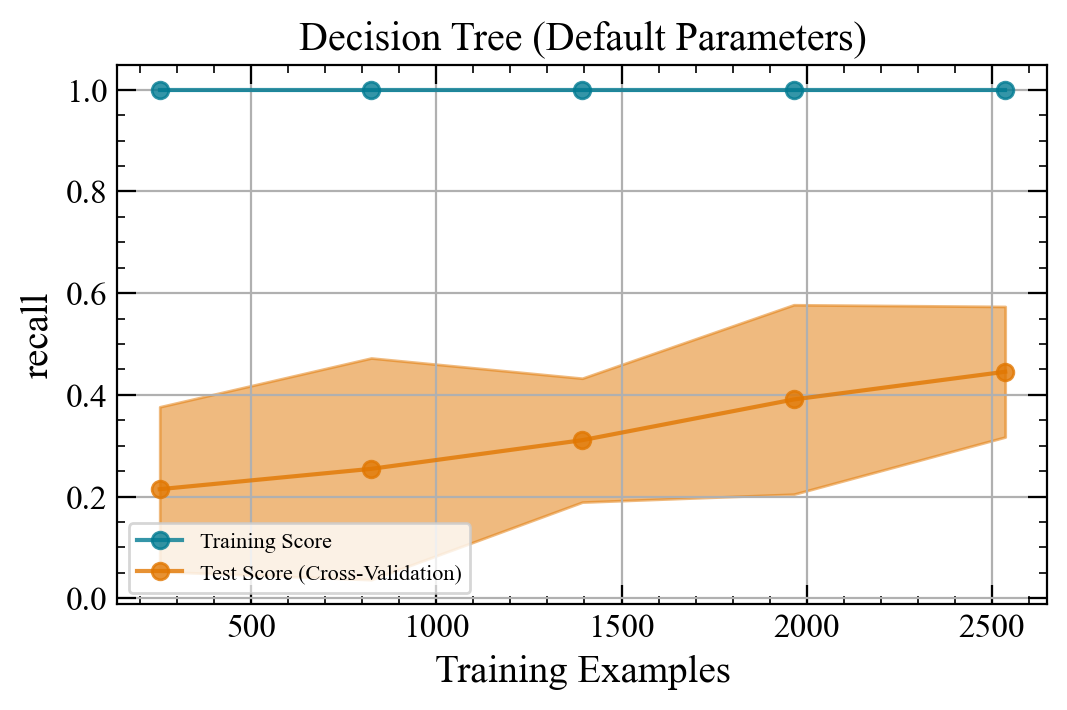

In [49]:
plot_learning_curve(model, 'Decision Tree (Default Parameters)', final_features,
                   targets, cv=cv_strat, scoring='recall')

In [50]:
model = neighbors.KNeighborsClassifier()
pipeline = Pipeline([('transformer', scaler), ('estimator', model)])

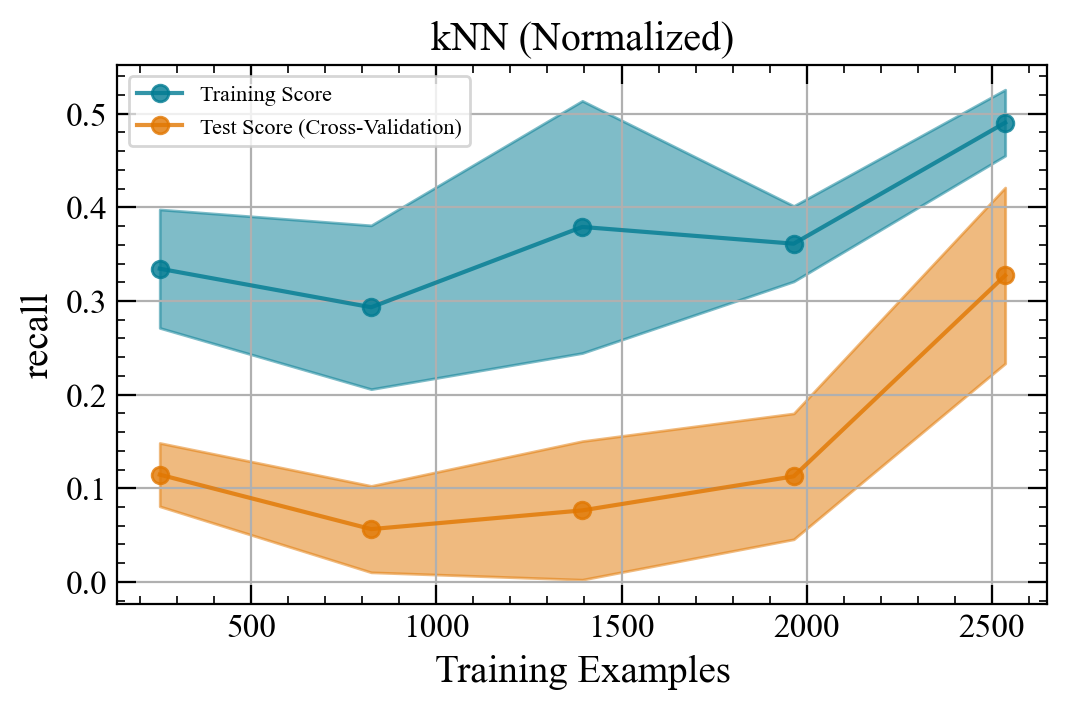

In [51]:
plot_learning_curve(pipeline, 'kNN (Normalized)', final_features,
                   targets, cv=cv_strat, scoring='recall')